<a href="https://colab.research.google.com/github/danigallegdup/NUS-Stock-Data/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using LSTM
This project aims to predict stock prices using historical data and Long Short-Term Memory (LSTM) neural networks.

## Data Loading and Preprocessing

In [2]:
!pip install optuna
#######################################################
# Import necessary libraries
########################################################
import torch
from google.colab import drive
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import numpy as np



In [3]:
#######################################################
# Data Loading and Preprocessing
########################################################

# Mount Google Drive
drive.mount('/content/drive')
# Load the dataset (had to make a shortcut from "Shared with Me" to MyDrive)
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)


Mounted at /content/drive


In [4]:
#######################################################
#  Data Transformation
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]

# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

# Replace the original sp500 DataFrame with the modified one
sp500 = new_sp500
sp500

print(sp500) # test case


<ipython-input-4-c98b8fed5e98>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


            Date    Price Type of Price
0     2005-02-25  104.770          open
1     2005-02-25  105.340       average
2     2005-02-25  105.790         close
3     2005-02-28  105.550          open
4     2005-02-28  105.120       average
...          ...      ...           ...
9598  2017-11-09  257.375       average
9599  2017-11-09  258.170         close
9600  2017-11-10  257.730          open
9601  2017-11-10  257.790       average
9602  2017-11-10  258.090         close

[9603 rows x 3 columns]


In [6]:
#######################################################
#  Scaling and Data Splitting
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Constants for scaling, data split, and sequence overlap
SCALING_RANGE = (-1, 1)  # Feature range for MinMaxScaler
TRAIN_TEST_SPLIT_RATIO = 0.8  # Ratio for splitting data into train and test
SEQUENCE_OVERLAP = 10  # Overlap to ensure continuity in sequence-based models

# Initialize the MinMaxScaler with the specified scaling range
scaler = MinMaxScaler(feature_range=SCALING_RANGE)

# Fit the scaler on the 'Price' column and transform the data
# Reshape to (-1, 1) because the scaler expects a 2D array
sp500['Price'] = scaler.fit_transform(sp500['Price'].values.reshape(-1, 1))

# Now, split the scaled data into training and testing sets based on the defined split ratio
data = sp500['Price'].values
train_size = int(len(data) * TRAIN_TEST_SPLIT_RATIO)
train_data = data[:train_size]
test_data = data[train_size - SEQUENCE_OVERLAP:]  # Include overlap for sequence creation

# Convert predictions and actual values back to their original scale
actuals_rescaled = scaler.inverse_transform(np.array(test_data[SEQUENCE_OVERLAP:]).reshape(-1, 1))  # Adjust for overlap


In [8]:
######################################################
#  Custom Dataset Creation
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Constant for sequence length
SEQUENCE_LENGTH = 10  # Number of days to look back for prediction

class StockDataset(Dataset):
    def __init__(self, data, seq_length=SEQUENCE_LENGTH):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # The length is reduced by the sequence length to avoid out-of-bound errors
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Get a sequence of prices and the next price as the label
        x = self.data[index:index + self.seq_length]  # Sequence input
        y = self.data[index + self.seq_length]  # Label (next value in sequence)

        # Convert to PyTorch tensors and reshape x to (seq_length, 1)
        x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

# Instantiate the dataset with the SEQUENCE_LENGTH constant
dataset = StockDataset(data=sp500['Price'].values, seq_length=SEQUENCE_LENGTH)


In [9]:
#######################################################
#  DataLoader Setup
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Constants
BATCH_SIZE = 64  # Number of samples per batch
TRAIN_RATIO = 0.8  # Proportion of data used for training
SEQUENCE_LENGTH = 10  # Number of days used in each input sequence

# Create training and testing datasets with a defined sequence length
train_dataset = StockDataset(train_data, seq_length=SEQUENCE_LENGTH)
test_dataset = StockDataset(test_data, seq_length=SEQUENCE_LENGTH)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Calculate training and validation sizes based on the defined training ratio
train_size = int(TRAIN_RATIO * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into training and validation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])


In [10]:
#######################################################
#  Hyperparameter Tuning with Optuna
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Constants
N_TRIALS = 50            # Number of trials for Optuna
MAX_EPOCHS = 5           # Number of epochs for tuning (set low to speed up Optuna)
INPUT_SIZE = 1           # Number of input features for LSTM
OUTPUT_SIZE = 1          # Number of output features for LSTM
SEQ_LENGTH = 10          # Sequence length used in training (make sure this matches your StockDataset)
HIDDEN_SIZE_RANGE = (50, 200)  # Range for hidden layer size in LSTM
NUM_LAYERS_RANGE = (1, 3)      # Range for the number of LSTM layers
LEARNING_RATE_RANGE = (1e-5, 1e-1)  # Range for learning rate
BATCH_SIZE_OPTIONS = [16, 32, 64, 128]  # Options for batch size

#######################################################
#  Hyperparameter Tuning with Optuna
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters within specified ranges
    learning_rate = trial.suggest_loguniform('learning_rate', *LEARNING_RATE_RANGE)
    hidden_size = trial.suggest_int('hidden_size', *HIDDEN_SIZE_RANGE)
    num_layers = trial.suggest_int('num_layers', *NUM_LAYERS_RANGE)
    batch_size = trial.suggest_categorical('batch_size', BATCH_SIZE_OPTIONS)

    # Define the LSTM model with the suggested parameters
    class LSTMStockPredictor(nn.Module):
        def __init__(self, input_size=INPUT_SIZE, hidden_layer_size=hidden_size, output_size=OUTPUT_SIZE):
            super(LSTMStockPredictor, self).__init__()
            self.hidden_layer_size = hidden_layer_size
            self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_layer_size, output_size)

        def forward(self, input_seq):
            lstm_out, _ = self.lstm(input_seq)
            predictions = self.linear(lstm_out[:, -1, :])
            return predictions

    # Initialize the model, loss function, and optimizer with the suggested hyperparameters
    model = LSTMStockPredictor()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoaders with the suggested batch size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Train the model for a few epochs to save time during tuning
    model.train()
    for epoch in range(MAX_EPOCHS):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            seq = seq.view(-1, SEQ_LENGTH, INPUT_SIZE)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, OUTPUT_SIZE))
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq = seq.view(-1, SEQ_LENGTH, INPUT_SIZE)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, OUTPUT_SIZE))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

# Create the study and run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

# Extract the best hyperparameters
best_params = study.best_trial.params
print(f"Best parameters found: {best_params}")

[I 2024-11-14 08:21:56,451] A new study created in memory with name: no-name-cd2348c9-be47-4439-ada6-de5d73b97956
<ipython-input-10-8cbe20a4f55a>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', *LEARNING_RATE_RANGE)
[I 2024-11-14 08:22:25,295] Trial 0 finished with value: 0.00027311785531007143 and parameters: {'learning_rate': 0.0005068729016653022, 'hidden_size': 57, 'num_layers': 3, 'batch_size': 32}. Best is trial 0 with value: 0.00027311785531007143.
<ipython-input-10-8cbe20a4f55a>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', *LEARNING_RATE_RAN

Best parameters found: {'learning_rate': 0.017708929525644124, 'hidden_size': 50, 'num_layers': 2, 'batch_size': 16}


In [13]:
#######################################################
# Model Definition and Training with Best Parameters
#######################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Extract the best parameters from the Optuna study
best_params = study.best_trial.params
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

# Define the final model with the best parameters
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=hidden_size, output_size=1):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Initialize the final model, loss function, and optimizer with the best hyperparameters
model = LSTMStockPredictor()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoaders with the best batch size
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Lists to store the loss values for plotting
train_losses = []
val_losses = []


Epoch 1/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 2/20, Training Loss: 0.0002, Validation Loss: 0.0002
Epoch 3/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 4/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 6/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 7/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 8/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 9/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 10/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 11/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 12/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/20, Training Loss: 0.0001, Validation Loss: 0.0002
Epoch 14/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 16/20, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 17/20, Training Loss: 0.0001, Validation Lo

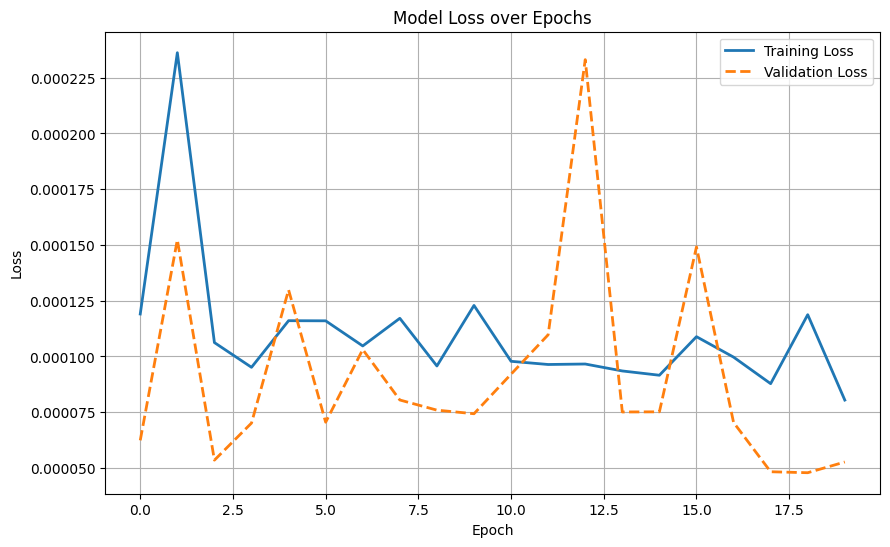

In [16]:
#######################################################
#  Training and Validation
#######################################################
"""
Implementation: Explain each code component /20
Technical Justification: Rationale behind each choice /10
Results Interpretation: How to interpret loss trends /10
Related Work: Relevant LSTM and Optuna studies /4
"""

# Hyperparameters and Configurations
NUM_EPOCHS = 20           # Number of epochs for final training
SEQ_LENGTH = 10           # Sequence length, can adjust based on data preprocessing
BATCH_SIZE = best_params['batch_size']  # Batch size from best parameters

# Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Training and Validation Loop
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    val_loss = 0.0

    # Training Loop
    model.train()
    for seq, labels in train_loader:
        optimizer.zero_grad()
        seq = seq.view(-1, SEQ_LENGTH, 1)  # Ensure correct input shape
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for seq, labels in val_loader:
            seq = seq.view(-1, SEQ_LENGTH, 1)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, 1))
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linestyle='--', linewidth=2)
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Model Evaluation on Test Set
model.eval()

# Define DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize lists for predictions and actual values
test_predictions = []
test_actuals = []

# Evaluation loop
with torch.no_grad():
    for seq, labels in test_loader:
        # Ensure input sequence has the correct shape
        seq = seq.view(-1, SEQ_LENGTH, 1)

        # Get predictions
        y_pred = model(seq)

        # Check and adjust shape if needed
        if y_pred.dim() == 0:
            # If y_pred is a single scalar, convert it directly
            test_predictions.append(y_pred.item())
        else:
            # Otherwise, extend the list with predictions
            test_predictions.extend(y_pred.view(-1).tolist())

        # Store actual values similarly
        if labels.dim() == 0:
            test_actuals.append(labels.item())
        else:
            test_actuals.extend(labels.view(-1).tolist())

# Reshape predictions and actuals for inverse scaling
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_actuals = np.array(test_actuals).reshape(-1, 1)

# Use scaler to transform values back to original range
predictions_rescaled = scaler.inverse_transform(test_predictions)
actuals_rescaled = scaler.inverse_transform(test_actuals)




In [17]:
#######################################################
#  Performance Metrics
########################################################
"""
Implementation: explain what makes this code good /20
Technical Justification: Why we chose to do what we did /10
Results Interpretation: /10
Related Work: Sources and References /4
"""

# Calculate MAE
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
print(f'MAE: {mae}')

# Calculate R-Squared
r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'R²: {r2}')

# Calculate RMSE between rescaled predictions and actual values
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')

MAE: 0.007568129690781911
R²: 0.9914970949614077
RMSE: 0.009633746668212543


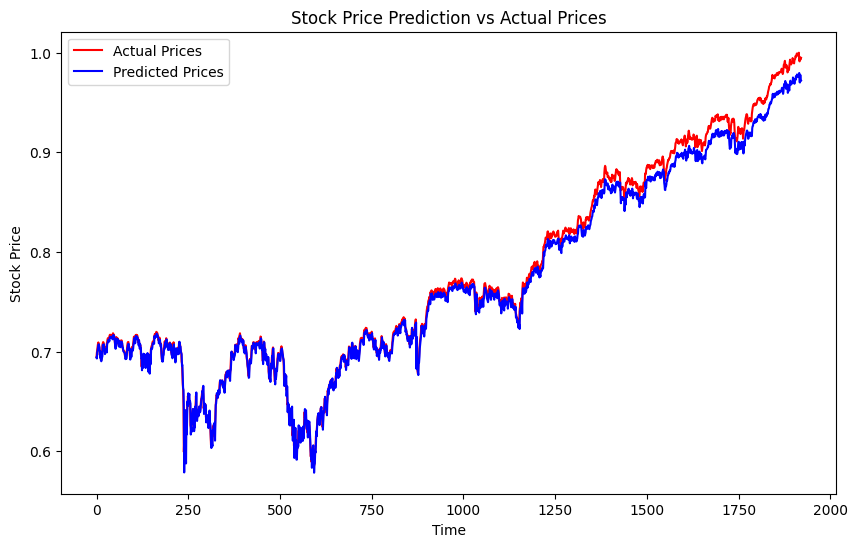

In [41]:
#######################################################
#  Prediction Accuracy Visualization
#######################################################
"""
Implementation: Explain each code component /20
Technical Justification: Rationale behind each choice /10
Results Interpretation: How to interpret visualized trends /10
Related Work: Relevant LSTM and time-series prediction studies /4
"""

# Visualization Settings
FIGURE_SIZE = (10, 6)         # Figure dimensions for the plot
ACTUAL_COLOR = 'red'          # Color for actual prices line
PREDICTED_COLOR = 'blue'      # Color for predicted prices line
PLOT_TITLE = 'Stock Price Prediction vs Actual Prices'
X_LABEL = 'Time'
Y_LABEL = 'Stock Price'

# Plot the rescaled predictions and actual values
plt.figure(figsize=FIGURE_SIZE)
plt.plot(actuals_rescaled, label='Actual Prices', color=ACTUAL_COLOR)
plt.plot(predictions_rescaled, label='Predicted Prices', color=PREDICTED_COLOR)
plt.title(PLOT_TITLE)
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.show()


MAE: 0.007568129690781911
R²: 0.9914970949614077
RMSE: 0.009633746668212543


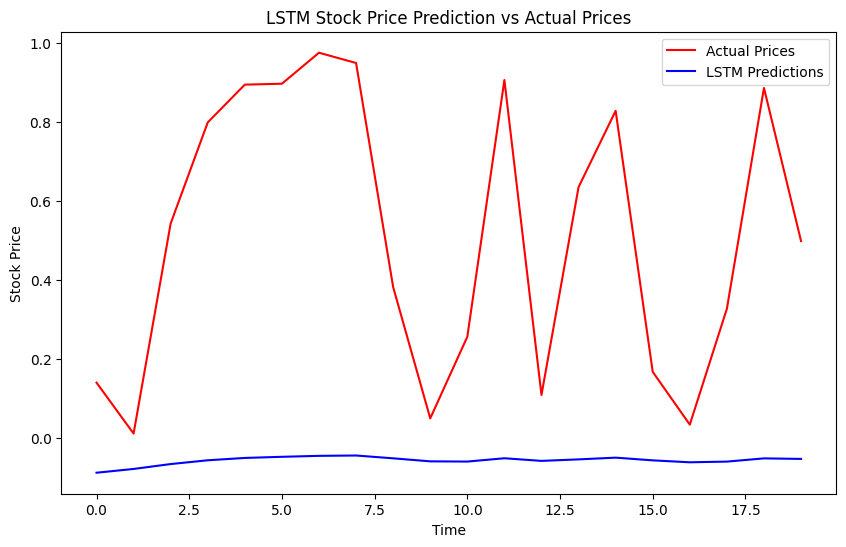

In [44]:
#######################################################
# LSTM Model Prediction Visualization
#######################################################
"""
Implementation: Visualizes LSTM model predictions compared to actual prices on the same scaling used for other models.
Technical Justification: Allows isolated evaluation of LSTM performance against actual stock prices.
Results Interpretation: Helps determine the LSTM model's ability to capture trends in stock prices.
"""

# Configuration Constants for Visualization
FIGURE_SIZE = (10, 6)           # Figure dimensions for the plot
ACTUAL_COLOR = 'red'            # Color for actual prices line
PREDICTED_COLOR = 'blue'        # Color for LSTM predicted prices line
PLOT_TITLE = 'LSTM Stock Price Prediction vs Actual Prices'
X_LABEL = 'Time'
Y_LABEL = 'Stock Price'

# Step 1: Generate LSTM Predictions on Scaled Data and Rescale
# Assuming the LSTM model (`lstm_model`) is already trained and available

# Calculate MAE
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
print(f'MAE: {mae}')

# Calculate R-Squared
r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'R²: {r2}')

# Calculate RMSE between rescaled predictions and actual values
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')

# Prepare test data for LSTM input and collect predictions
test_data_tensor = torch.FloatTensor(test_data_scaled).view(-1, 1, 1)  # Reshape for LSTM input
lstm_predictions_scaled = []

with torch.no_grad():
    for i in range(len(test_data_tensor)):
        seq = test_data_tensor[:i+1]
        lstm_predictions_scaled.append(lstm_model(seq).item())

# Convert LSTM predictions to original scale
lstm_predictions_scaled = np.array(lstm_predictions_scaled)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled.reshape(-1, 1)).flatten()

# Rescale y_test for comparison with LSTM predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 2: Plot LSTM Predictions vs Actual Prices
plt.figure(figsize=FIGURE_SIZE)
plt.plot(y_test_rescaled, label='Actual Prices', color=ACTUAL_COLOR)
plt.plot(lstm_predictions, label='LSTM Predictions', color=PREDICTED_COLOR)

plt.title(PLOT_TITLE)
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.show()



Moving Average Performance:
MAE: 0.3357331939608731, RMSE: 0.37018002321955246, R²: -0.13163011233529054
Linear Regression Performance:
MAE: 0.32108621096395407, RMSE: 0.35445870730154394, R²: -0.03755191738884478
ARIMA Model Performance:
MAE: 0.3172735247945011, RMSE: 0.3486498962390772, R²: -0.003824102801958329
LSTM Model Performance:
MAE: 0.007568129690781911, RMSE: 0.9914970949614077, R²: 0.009633746668212543


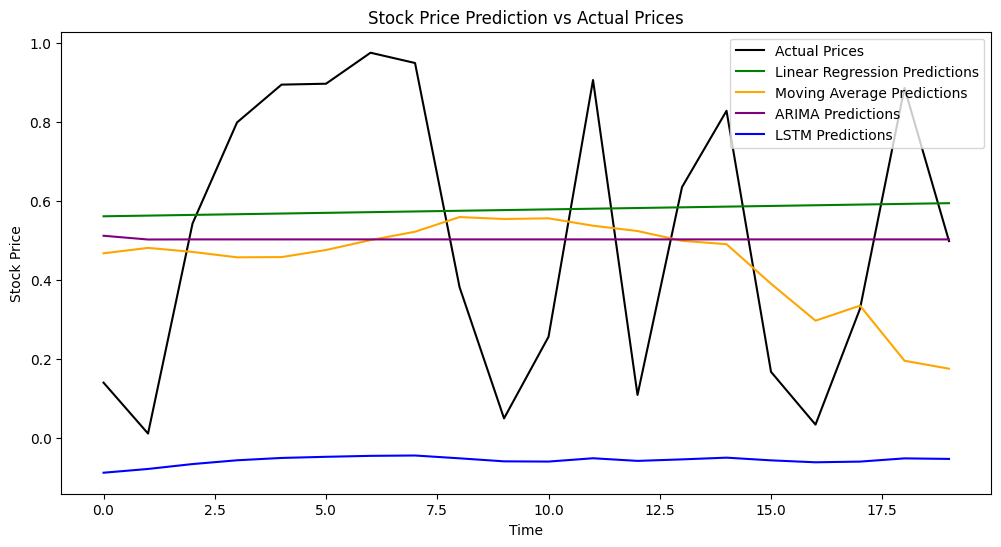

MAE: 0.007568129690781911
R²: 0.9914970949614077
RMSE: 0.009633746668212543


In [43]:
#######################################################
# Baseline Model - Linear Regression, Moving Average, ARIMA, and LSTM
#######################################################
"""
Implementation: This script benchmarks time-series models (Moving Average, ARIMA, Linear Regression, and LSTM) for stock price prediction.
                Calculates performance metrics (MAE, RMSE, R²) and visualizes predictions against actual prices.
Technical Justification: Each model provides a different approach to time-series forecasting.
Results Interpretation: MAE, RMSE, and R² are used to assess model accuracy.
Related Work: Moving Average and ARIMA are traditional models; Linear Regression assumes a linear trend; LSTM applies deep learning to capture complex temporal patterns.
"""



# Configuration Constants
WINDOW_SIZE = 20                # Moving Average window size - larger windows capture more trend but lose sensitivity to short-term changes
ARIMA_ORDER = (1, 1, 1)         # ARIMA model order (p, d, q) - set for simplicity, may need adjustment based on data characteristics
FIGURE_SIZE = (12, 6)           # Plot dimensions
ACTUAL_COLOR = 'black'          # Color for actual prices in the plot
PREDICTION_COLORS = {           # Colors for each model's predictions
    'Linear Regression': 'green',
    'Moving Average': 'orange',
    'ARIMA': 'purple',
    'LSTM': 'blue'
}
PLOT_TITLE = 'Stock Price Prediction vs Actual Prices'
X_LABEL = 'Time'
Y_LABEL = 'Stock Price'

# Step 1: Data Scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Step 2: Moving Average Model
moving_avg_predictions_scaled = calculate_moving_average_predictions(train_data_scaled, test_data_scaled, WINDOW_SIZE)
moving_avg_predictions = scaler.inverse_transform(moving_avg_predictions_scaled.reshape(-1, 1)).flatten()

# Step 3: Linear Regression Baseline Model
lr_predictions_scaled = linear_regression_baseline(train_data_scaled, test_data_scaled)
lr_predictions = scaler.inverse_transform(lr_predictions_scaled.reshape(-1, 1)).flatten()

# Step 4: ARIMA Model
arima_predictions_scaled = fit_arima_model(train_data_scaled, ARIMA_ORDER)
arima_predictions = scaler.inverse_transform(arima_predictions_scaled.reshape(-1, 1)).flatten()

# Step 5: LSTM Model
# Define LSTM Model (simplified example)
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[-1])
        return predictions

# Initialize and train the LSTM model (ensure training data is prepared appropriately)
# Here we assume you have a trained LSTM model or will replace with the code to train it.
lstm_model = LSTMModel()
# Load or train your LSTM model here
# ...

# LSTM Prediction
# Prepare test data for LSTM input (reshape appropriately for LSTM requirements)
test_data_tensor = torch.FloatTensor(test_data_scaled).view(-1, 1, 1)  # (seq_len, batch, input_size)
lstm_predictions_scaled = []

with torch.no_grad():
    for i in range(len(test_data_tensor)):
        seq = test_data_tensor[:i+1]
        lstm_predictions_scaled.append(lstm_model(seq).item())

# Convert LSTM predictions to original scale
lstm_predictions_scaled = np.array(lstm_predictions_scaled)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled.reshape(-1, 1)).flatten()

# Check y_test after inverse scaling (original scale) to ensure consistency in comparison
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 6: Performance Metrics Calculation
ma_mae, ma_rmse, ma_r2 = calculate_metrics(y_test_rescaled, moving_avg_predictions)
lr_mae, lr_rmse, lr_r2 = calculate_metrics(y_test_rescaled, lr_predictions)
arima_mae, arima_rmse, arima_r2 = calculate_metrics(y_test_rescaled, arima_predictions)

# LSTM
lstm_mae= mean_absolute_error(actuals_rescaled, predictions_rescaled)
# Calculate R-Squared
lstm_rmse = r2_score(actuals_rescaled, predictions_rescaled)
# Calculate RMSE between rescaled predictions and actual values
lstm_r2 = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))


# Display model performance metrics
print("Moving Average Performance:")
print(f"MAE: {ma_mae}, RMSE: {ma_rmse}, R²: {ma_r2}")
print("Linear Regression Performance:")
print(f"MAE: {lr_mae}, RMSE: {lr_rmse}, R²: {lr_r2}")
print("ARIMA Model Performance:")
print(f"MAE: {arima_mae}, RMSE: {arima_rmse}, R²: {arima_r2}")
print("LSTM Model Performance:")
print(f"MAE: {lstm_mae}, RMSE: {lstm_rmse}, R²: {lstm_r2}")

# Step 7: Visualization
plt.figure(figsize=FIGURE_SIZE)
plt.plot(y_test_rescaled, label='Actual Prices', color=ACTUAL_COLOR)
plt.plot(lr_predictions, label='Linear Regression Predictions', color=PREDICTION_COLORS['Linear Regression'])
plt.plot(moving_avg_predictions, label='Moving Average Predictions', color=PREDICTION_COLORS['Moving Average'])
plt.plot(arima_predictions, label='ARIMA Predictions', color=PREDICTION_COLORS['ARIMA'])
plt.plot(lstm_predictions, label='LSTM Predictions', color=PREDICTION_COLORS['LSTM'])

plt.title(PLOT_TITLE)
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.show()


# Calculate MAE
my_mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
print(f'MAE: {my_mae}')

# Calculate R-Squared
my_r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'R²: {my_r2}')

# Calculate RMSE between rescaled predictions and actual values
my_rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f'RMSE: {my_rmse}')


## old code --> wrting up the documentation for new code


## Neural Network Architecture

References: To put in our presentation or somewhere later <br>
https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/ <br>
https://www.coursera.org/in/articles/types-of-neural-networks

In our project, we decided to utilise Long short-term memory (LSTM) networks. LSTMs are a specialised type of recurrent neural network architecture, specifically designed to remember information over extended periods of time. This makes them the perfect model to use for our time-series data.


Originally use 'Close' price as we deduced it as most relevant and stable data and introduce the least amount of noise. But now I that I think of it that could be the main reason it is overfitting lol

In [ ]:
print(sp500) # test case

scaler = MinMaxScaler(feature_range=(-1, 1))
sp500['Price'] = scaler.fit_transform(sp500['Price'].values.reshape(-1, 1))

            Date    Price Type of Price
0     2005-02-25  104.770          open
1     2005-02-25  105.340       average
2     2005-02-25  105.790         close
3     2005-02-28  105.550          open
4     2005-02-28  105.120       average
...          ...      ...           ...
9598  2017-11-09  257.375       average
9599  2017-11-09  258.170         close
9600  2017-11-10  257.730          open
9601  2017-11-10  257.790       average
9602  2017-11-10  258.090         close

[9603 rows x 3 columns]


## Normalizing the Data

In [ ]:

# Initialize the MinMaxScaler with a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the 'Price' column and transform the data
# Reshape to (-1, 1) because the scaler expects a 2D array
sp500['Price'] = scaler.fit_transform(sp500['Price'].values.reshape(-1, 1))

# Now, split the scaled data into training and testing sets
data = sp500['Price'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size - 10:]  # Include overlap for sequence creation

# After creating predictions, use the scaler to revert them back to the original scale:
# predictions_rescaled = scaler.inverse_transform(predictions)
# actuals_rescaled = scaler.inverse_transform(actuals)


In [ ]:
# Convert predictions and actual values back to their original scale
# predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actuals_rescaled = scaler.inverse_transform(np.array(test_data[10:]).reshape(-1, 1))  # Adjust for the overlap


## Prepare Dataset for PyTorch

In [ ]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # The length is reduced by the sequence length to avoid out-of-bound errors
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Get a sequence of prices and the next price as the label
        x = self.data[index:index + self.seq_length]  # Sequence input
        y = self.data[index + self.seq_length]  # Label (next value in sequence)

        # Convert to PyTorch tensors and reshape x to (seq_length, 1)
        x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y


In [ ]:
# Define the sequence length (e.g., 10 for predicting based on 10 days of past data)
seq_length = 10

# Create training and testing datasets
train_dataset = StockDataset(train_data, seq_length=seq_length)
test_dataset = StockDataset(test_data, seq_length=seq_length)

# Create DataLoaders for training and testing datasets
# Batch size is set to 64 for training, adjust based on memory capacity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Define LSTM Model

In [ ]:
#######################################################
#  Imports and Data Preparation
########################################################
# Define the proportion of training and validation data (e.g., 80% train, 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])


In [ ]:
#######################################################
#  Hyperparameter Tuning with optuna
########################################################
# Define the objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    hidden_size = trial.suggest_int('hidden_size', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Define the LSTM model with the suggested parameters
    class LSTMStockPredictor(nn.Module):
        def __init__(self, input_size=1, hidden_layer_size=hidden_size, output_size=1):
            super(LSTMStockPredictor, self).__init__()
            self.hidden_layer_size = hidden_layer_size
            self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_layer_size, output_size)

        def forward(self, input_seq):
            lstm_out, _ = self.lstm(input_seq)
            predictions = self.linear(lstm_out[:, -1, :])
            return predictions

    # Initialize the model, loss function, and optimizer with the suggested hyperparameters
    model = LSTMStockPredictor()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoaders with the suggested batch size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Train the model for a few epochs to save time during tuning
    model.train()
    for epoch in range(5):  # Using a smaller number of epochs for quick tuning
        for seq, labels in train_loader:
            optimizer.zero_grad()
            seq = seq.view(-1, seq_length, 1)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq = seq.view(-1, seq_length, 1)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, 1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss



In [ ]:
# Create the study and run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Extract the best hyperparameters
best_params = study.best_trial.params
learning_rate = best_params['learning_rate']
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
batch_size = best_params['batch_size']

print(f"Best parameters found: {best_params}")


[I 2024-11-12 12:58:00,910] A new study created in memory with name: no-name-84976fa2-9302-4fa7-9641-227bb6a2a43b
<ipython-input-14-87fc760dde0b>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-11-12 12:58:42,848] Trial 0 finished with value: 0.00015412171417968543 and parameters: {'learning_rate': 0.023038787809510228, 'hidden_size': 178, 'num_layers': 2, 'batch_size': 32}. Best is trial 0 with value: 0.00015412171417968543.
<ipython-input-14-87fc760dde0b>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-11-12 12:5

Best parameters found: {'learning_rate': 0.011048716723474572, 'hidden_size': 151, 'num_layers': 1, 'batch_size': 16}


In [ ]:

# Define the final model with the best parameters
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=hidden_size, output_size=1):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_layer_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


In [ ]:
# Initialize the final model, loss function, and optimizer with the best hyperparameters
model = LSTMStockPredictor()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoaders with the best batch size
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Lists to store the loss values for plotting
train_losses = []
val_losses = []


Epoch 1/20, Training Loss: 0.0009, Validation Loss: 0.0000
Epoch 2/20, Training Loss: 0.0001, Validation Loss: 0.0002
Epoch 3/20, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 4/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 5/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 6/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 7/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 8/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 9/20, Training Loss: 0.0000, Validation Loss: 0.0001
Epoch 10/20, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 11/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 12/20, Training Loss: 0.0000, Validation Loss: 0.0001
Epoch 13/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 14/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 15/20, Training Loss: 0.0000, Validation Loss: 0.0001
Epoch 16/20, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 17/20, Training Loss: 0.0000, Validation Lo

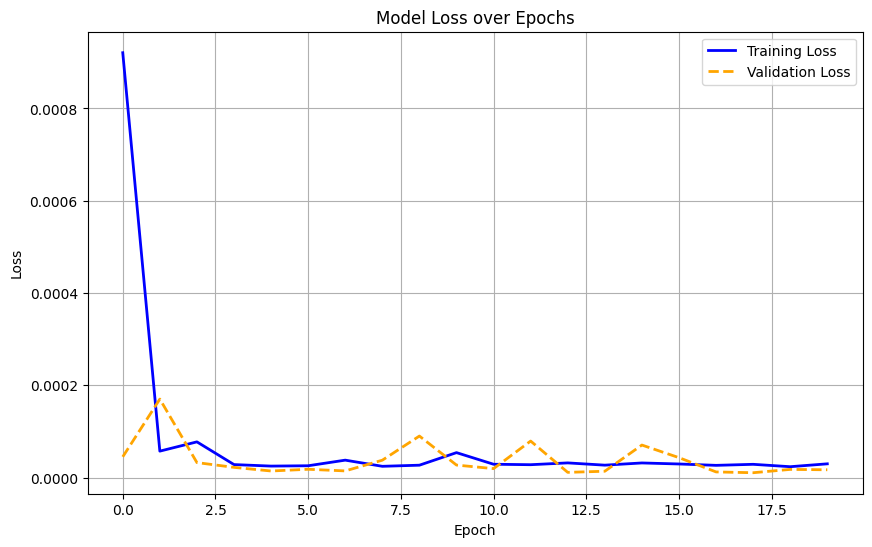

In [ ]:
# Training with validation
num_epochs = 20  # Number of epochs for final training
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training Loop
    model.train()
    for seq, labels in train_loader:
        optimizer.zero_grad()
        seq = seq.view(-1, seq_length, 1)
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for seq, labels in val_loader:
            seq = seq.view(-1, seq_length, 1)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, 1))
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

model.eval()  # Set the model to evaluation mode

test_predictions = []
test_data = []

In [ ]:
# Define a DataLoader for the test dataset if not already defined
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Initialize lists to store predictions and actual values
test_predictions = []
test_data = []

# Evaluation loop
with torch.no_grad():
    for seq, labels in test_loader:  # Use test_loader for evaluation
        # Initialize the hidden state for the LSTM (if necessary)
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        # Ensure the input sequence shape is (seq_length, batch_size, input_size)
        seq = seq.view(seq_length, -1, 1)

        # Get the model's predictions
        y_pred = model(seq)

        # Append each prediction and corresponding label
        for prediction, actual in zip(y_pred, labels):
            test_predictions.append(prediction.item())  # Convert each prediction to a Python scalar
            test_data.append(actual.item())  # Convert each actual label to a scalar

# Convert lists to NumPy arrays and reshape to (-1, 1) for inverse transformation
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_data = np.array(test_data).reshape(-1, 1)

# Use the scaler to inverse transform the scaled values back to their original range
predictions_rescaled = scaler.inverse_transform(test_predictions)
actuals_rescaled = scaler.inverse_transform(test_data)


In [ ]:
# Calculate MAE
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
print(f'MAE: {mae}')

# Calculate R-Squared
r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'R²: {r2}')

# Calculate RMSE between rescaled predictions and actual values
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')

MAE: 0.02174896433589659
R²: 0.976584131541073
RMSE: 0.03186594124797789


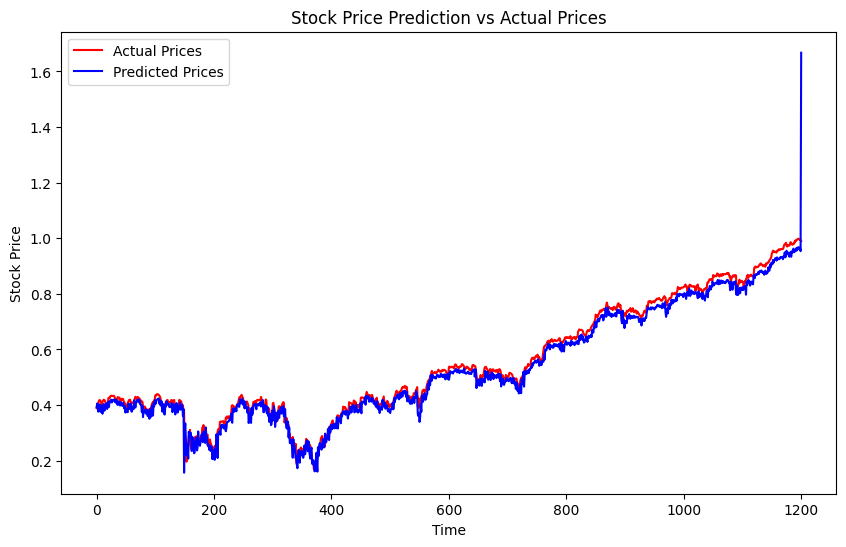

In [ ]:

# Plot the rescaled predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(actuals_rescaled, label='Actual Prices', color='red')
plt.plot(predictions_rescaled, label='Predicted Prices', color='blue')
plt.title('Stock Price Prediction vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()